2024-07-24 15:38:01.710126 :: pyACC.CosmologicalDistances  :: 68 0.319
2024-07-24 15:38:01.771383 :: pyACC.CosmologicalDistances  :: -0.0
2024-07-24 15:38:01.771633 :: pyACC.CosmologicalDistances  :: 70.0 0.3
2024-07-24 15:38:01.835409 :: pyACC.CosmologicalDistances  :: 70.0 0.3
2024-07-24 15:38:01.895121 :: pyACC.CosmologicalDistances  :: 71.0 0.3
2024-07-24 15:38:01.957844 :: pyACC.CosmologicalDistances  :: 68.381966 0.3
2024-07-24 15:38:02.031063 :: pyACC.CosmologicalDistances  :: 68.20796714740924 0.3
2024-07-24 15:38:02.099318 :: pyACC.CosmologicalDistances  :: 67.9264310879564 0.3
2024-07-24 15:38:02.158196 :: pyACC.CosmologicalDistances  :: 68.10042994492427 0.3
2024-07-24 15:38:02.220569 :: pyACC.CosmologicalDistances  :: 68.27442879313791 0.3
2024-07-24 15:38:02.285559 :: pyACC.CosmologicalDistances  :: 68.24799673026693 0.3
2024-07-24 15:38:02.355114 :: pyACC.CosmologicalDistances  :: 68.23047669755961 0.3
2024-07-24 15:38:02.426539 :: pyACC.CosmologicalDistances  :: 68.24799

/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


2024-07-24 15:38:02.750690 :: pyACC.CosmologicalDistances  :: 68.24799673026693 0.31413576796630516
2024-07-24 15:38:02.827760 :: pyACC.CosmologicalDistances  :: 68.24799673026693 0.30688585869302737
2024-07-24 15:38:02.905708 :: pyACC.CosmologicalDistances  :: 68.24799673026693 0.30695471728995766
2024-07-24 15:38:02.977920 :: pyACC.CosmologicalDistances  :: 68.24799673026693 0.3068170000960971
2024-07-24 15:38:03.047947 :: pyACC.CosmologicalDistances  :: 66.49599346053387 0.31377171738605475
2024-07-24 15:38:03.123714 :: pyACC.CosmologicalDistances  :: 68.24799673026693 0.30688585869302737
2024-07-24 15:38:03.197902 :: pyACC.CosmologicalDistances  :: 66.49599346053387 0.31377171738605475
2024-07-24 15:38:03.266090 :: pyACC.CosmologicalDistances  :: 71.0827975888062 0.2957443052085135
2024-07-24 15:38:03.332453 :: pyACC.CosmologicalDistances  :: 69.33079427499975 0.30263016407476157
2024-07-24 15:38:03.398058 :: pyACC.CosmologicalDistances  :: 67.57879104934007 0.3095160225945683
2024

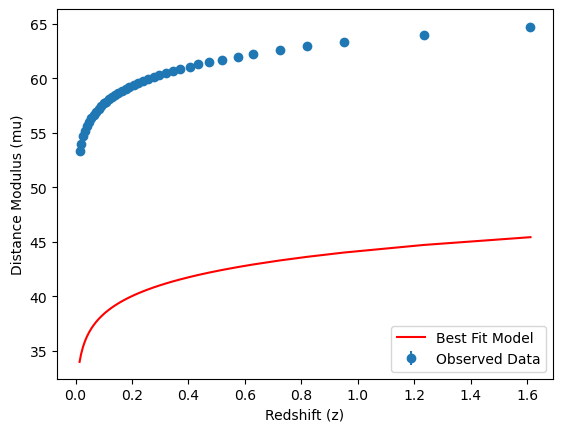

In [24]:
import sys
sys.path.append("../")

import numpy as np
import math as m
from scipy.optimize import minimize
import sys
import platform
import os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import camb
import pandas as pd

# Import pyACC logger
from pyACC.helpers import Logger

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Import integration class
from pyACC.Cosmology.distances import Dc, Dc_w0wa

# Load the data
file_path = 'binned_data.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Implement your favourite Hubble function
def hubble_function(z,omega_mat,omega_rad,w,H0):
    return H0*m.sqrt(omega_mat*(1+z)**3 + omega_rad*(1+z)**4 + (1 - omega_mat - omega_rad)*(1+z)**(3*(1+w)))

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z_lista = data['zcmb'].values



mu = []
for z_prime in z_lista:
    mu.append(5*np.log10(Dc(hubble_function,z_prime,0.319,0,-1,68)*(1+z_prime)) + 25)

data['mb'] = mu
# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0 = params #, w0, wa
    print(H0, Om0)
    if Om0 < 0:
        return -np.inf
    z = data['zcmb'].values
    d = data['mb'].values + 19.3
    mu = []
    for z_prime in z:
        mu.append(5*np.log10(Dc(hubble_function,z_prime,Om0,0,-1,H0)*(1+z_prime)) + 25) #it is equivalent to get_mu(z, H0, Om0, w0, wa)
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    
    return term1 

def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


from scipy.optimize import minimize

# Example data and covariance inverse matrix
z = data['zcmb'].values
d = data['mb'].values +19.3
dmb = data['dmb'].values
#error_mb = np.ones(len(dmb)) 

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [70, 0.3]
print(neg_ln_likelihood([68, 0.319], data, np.linalg.inv(np.diag(dmb**2))))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv), method='Powell') # , method='Powell'
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
best_fit_params = result.x
print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")
print(result)


# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Om0_best = best_fit_params
mu_best = []
for z_prime in z:
    #mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, Om0_best, 0, -1, H0_best) * (1 + z_prime)) + 25)
    mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, 0.319, 0, -1, 68.) * (1 + z_prime)) + 25)

# mb is mu +19.3, so:
y = data['mb'].values + 19.3 # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()


Cose che ho provato a cambiare:
ho messo erroe su z --> NON CAMBIA NULLA
ho cambiato errore in sigma (da 1 a 0.000001) --> NON CAMBIA NULLA
ho cambiato il mu_best --> viene giusto -->ha senso perche se non cambio mu_best mi vengono: H0 = 40000 e omega_mat = 1000
cambierò (qua sotto) il procedimento di minimize --> NON CAMBIA NULLA (valori di H0 e omega matter sembre sbagliati)

Cose che non ho cambiato:
likelihood (per es provare a cambiare la moltiplicazione fra le matrici) 
calcolo di mu --> è giusto il mio infatti l'ho confrontato con i dati (grafico sopra) e vengono (se metto omega matter e H0 giusti) 
data file --> sono giusti ovviamenti perche presi da PYTHON (e poi anche perche tornano con quello detto sopra con mu)


100%|██████████| 1000/1000 [31:32<00:00,  1.89s/it]


2024-07-24 11:38:06.610048 :: pyACC.CosmologicalDistances  :: MCMC result: H0 = 99.89161657063653, Om0 = 0.9941516382750769


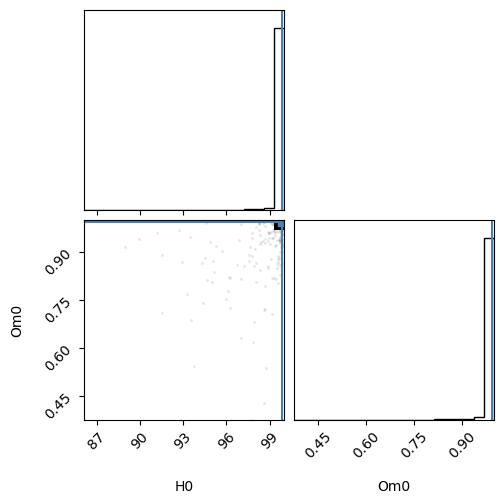

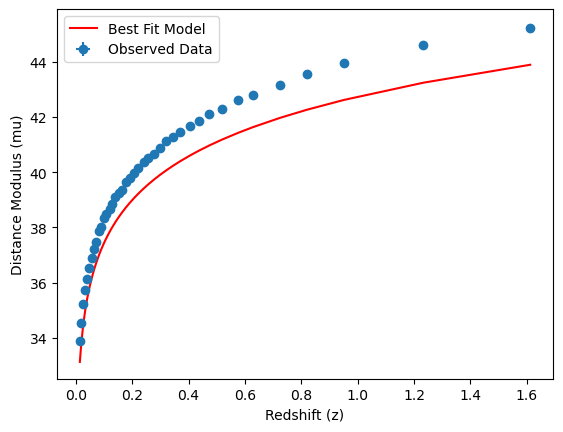

In [33]:
import numpy as np
import math as m
import pandas as pd
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pyACC.helpers import Logger
from pyACC.Cosmology.distances import Dc, Dc_w0wa

# Set the logger
print = Logger("pyACC.CosmologicalDistances")

# Load the data
file_path = 'binned_data.txt'
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Implement the Hubble function
def hubble_function(z, omega_mat, omega_rad, w, H0):
    return H0 * m.sqrt(omega_mat * (1 + z)**3 + omega_rad * (1 + z)**4 + (1 - omega_mat - omega_rad) * (1 + z)**(3 * (1 + w)))

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values
z_lista = data['zcmb'].values

# Define the log-likelihood function for MCMC
def ln_likelihood(params, data, cov_inv):
    H0, Om0 = params
    z = data['zcmb'].values
    d = data['mb'].values
    mu = []
    try:
        for z_prime in z:
            mu.append(5 * np.log10(Dc(hubble_function, z_prime, Om0, 0, -1, H0) * (1 + z_prime)) + 25)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    diff = d - mu
    return -0.5 * diff @ cov_inv @ diff

# Define the log-prior function
def ln_prior(params):
    H0, Om0 = params
    if 50 < H0 < 100 and 0 < Om0 < 1:
        return 0.0
    return -np.inf

# Define the log-probability function for MCMC
def ln_prob(params, data, cov_inv):
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Initial guess and covariance matrix
initial_guess = [70, 0.3]
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Run MCMC using emcee
ndim, nwalkers = 2, 50
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=(data, cov_inv))
sampler.run_mcmc(pos, 1000, progress=True)

# Get the MCMC samples and compute statistics
samples = sampler.get_chain(discard=100, thin=15, flat=True)
H0_mcmc, Om0_mcmc = np.mean(samples, axis=0)

print(f"MCMC result: H0 = {H0_mcmc}, Om0 = {Om0_mcmc}")

# Plot the MCMC samples
import corner
fig = corner.corner(samples, labels=["H0", "Om0"], truths=[H0_mcmc, Om0_mcmc])
plt.show()

# Generate model predictions using the MCMC best fit parameters
H0_best, Om0_best = H0_mcmc, Om0_mcmc
mu_best = []
for z_prime in z_lista:
    mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, Om0_best, 0, -1, H0_best) * (1 + z_prime)) + 25)

y = data['mb'].values + 19.3
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z_lista, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z_lista, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()


riprovo a rifare la prima cella ma usando CAMB e non la mia funzione

In [10]:
# Define the cosmological model, because later we will use it in the likelihood function
def get_mu(z, H0, Om0):
    #set the cosmology with camb
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=Om0, omch2=0.122, mnu=0.06, omk=0, tau=0.06) #ombh2 = 0.022
    pars.InitPower.set_params(ns=0.965, r=0)
    #pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25 #The constant 25 is added to adjust the units and to match the conventional definitions used in astronomy -->
    #--> for a luminosity distance of 10 Mpc, the distance modulus would be 30.
    return mu

# Define the likelihood function

def ln_likelihoods(params, data, cov_inv):
    H0, Om0 = params
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu = get_mu(z, H0, Om0)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff # @ is the matrix multiplication
    return term1

# Calculate the log likelihood
params = [70, 0.022]

log_likelihood = ln_likelihoods(params, data, cov_inv)
print(log_likelihood)
'''
def neg_ln_likelihood(params, data, cov_inv):
    return -2*ln_likelihood(params, data, cov_inv)


from scipy.optimize import minimize

# Example data and covariance inverse matrix
z = data['zcmb'].values
d = data['mb'].values
dmb = data['dmb'].values
#error_mb = np.ones(len(dmb)) 

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
cov_inv = np.linalg.inv(Sigma)

# Initial guess for the parameters [H0, Om0]
initial_guess = [70, 0.022]
#ln_likelihood([70, 0.3], data, np.linalg.inv(np.diag(dmb**2)))


# Run the optimizer
result = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv))
# Optimized parameters
optimized_params = result.x
optimized_log_likelihood = -result.fun

print("Optimized Parameters:", optimized_params)
print("Optimized Log Likelihood:", optimized_log_likelihood)

# Best fit parameters
best_fit_params = result.x
print(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")


# Generate model predictions using the best fit parameters
#z = data['zcmb'].values
H0_best, Om0_best = best_fit_params
mu_best = []
for z_prime in z:
    #mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, Om0_best, 0, -1, H0_best) * (1 + z_prime)) + 25)
    mu_best.append(5 * np.log10(Dc(hubble_function, z_prime, 0.319, 0, -1, 68.) * (1 + z_prime)) + 25)

# mb is mu +19.3, so:
y = data['mb'].values + 19.3 # cfr. Mari
#xerr = data['dz'].values

# Plot the observed data and model predictions
plt.errorbar(z, y, yerr=data['dmb'], fmt='o', label='Observed Data')
plt.plot(z, mu_best, 'r-', label='Best Fit Model')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mu)')
plt.legend()
plt.show()
'''

2024-07-24 13:16:52.484246 :: pyACC.CosmologicalDistances  :: -10779286.706796726


'\ndef neg_ln_likelihood(params, data, cov_inv):\n    return -2*ln_likelihood(params, data, cov_inv)\n\n\nfrom scipy.optimize import minimize\n\n# Example data and covariance inverse matrix\nz = data[\'zcmb\'].values\nd = data[\'mb\'].values\ndmb = data[\'dmb\'].values\n#error_mb = np.ones(len(dmb)) \n\n# Compute the covariance matrix\nSigma = np.diag(dmb**2)\ncov_inv = np.linalg.inv(Sigma)\n\n# Initial guess for the parameters [H0, Om0]\ninitial_guess = [70, 0.022]\n#ln_likelihood([70, 0.3], data, np.linalg.inv(np.diag(dmb**2)))\n\n\n# Run the optimizer\nresult = minimize(neg_ln_likelihood, initial_guess, args=(data, cov_inv))\n# Optimized parameters\noptimized_params = result.x\noptimized_log_likelihood = -result.fun\n\nprint("Optimized Parameters:", optimized_params)\nprint("Optimized Log Likelihood:", optimized_log_likelihood)\n\n# Best fit parameters\nbest_fit_params = result.x\nprint(f"Best fit parameters: H0 = {best_fit_params[0]}, Om0 = {best_fit_params[1]}")\n\n\n# Generate mo